# Sorting SEP events with our database by the SRS region

#### So, there are ~100 valid srs_region entries from the SEP database. There are over 900 matching entries in the big dataframe. So, we'll use this as a filter before appyling the 'nearest-date' function, and see where that leaves us!

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib.dates import DateFormatter
import datetime as dt
from datetime import timedelta

In [2]:
# Reading in the dataframes
custom_df1 = 'C:/Users/Peter/py_projects/solar_stats/custom_df.p'
custom_df2 = 'C:/Users/Peter/py_projects/solar_stats/custom_sep.p'
df = pd.read_pickle(custom_df1)
sp = pd.read_pickle(custom_df2)

In [3]:
# df data
all_regions = df.srs_active_region_no.dropna(how='any').astype(float)

In [4]:
# SEP data
sp_regions = sp.region.dropna(how='any')
print(sp_regions[pd.to_numeric(sp_regions, errors='coerce').isnull()])

23      Filament
26    9212,13,18
Name: region, dtype: object


In [5]:
sp_regions.replace('9212,13,18','9212', regex=True, inplace=True)
sp_regions.replace('Filament', np.nan, regex=True, inplace=True)

In [6]:
# Dropping the 'filament' nan
sp_regions = sp_regions.dropna(how='any').astype(float)

In [7]:
# Looking at which entries in all_regions match any from sp_regions
bools = all_regions.isin(sp_regions)

# keeping entries of boolean True only
bools = bools[bools]

In [8]:
# Getting the True indices and using to create a new filtered df 
idx = bools.index.tolist()
df2 = df.loc[idx]

In [9]:
# Properties to look at (limiting to max and min dates from the SEP data)
fls = df2[['flare_start_time', 'flare_peak_time', 'cme_speed', 'srs_active_region_no']]
fls = fls.dropna(how='any')
fls = fls[ (fls['flare_start_time'] >= dt.datetime(1997, 11, 4)) & (fls['flare_start_time'] <= dt.datetime(2017, 9, 6)) ] 
fls = fls.reset_index(drop=True)

spf = sp[['proton_flux', 'flare_max', 'region']]
spf = spf.dropna(how='any')
spf = spf.reset_index(drop=True)

In [10]:
# found this online to find the value in the 'items' column closest to the 'pivot' value
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [11]:
# Finding all the nearest values for the flare_peak_time to the SEP flare_max 
both = (np.zeros(len(spf.flare_max))).astype('O')
for i in range(len(both)):
    both[i] = nearest(fls.flare_peak_time, spf.flare_max.iloc[i])

In [12]:
# Now getting the indices for these nearest values
idxb = np.zeros(len(both))
for j in range(len(idxb)):
    b = fls['flare_peak_time'].index[fls.flare_peak_time==both[j]].tolist()
    idxb[j] = b[0]

In [13]:
# Now to keep only the corresponding data for these entries
fls2 = fls.loc[idxb]

In [14]:
fls2

flare_start_time     flare_peak_time  cme_speed srs_active_region_no
0.0   1997-11-04 05:52:00 1997-11-04 05:58:00      785.0                 8100
2.0   1997-11-06 03:12:00 1997-11-06 03:18:00      307.0                 8100
5.0   1998-04-25 14:02:00 1998-04-25 14:39:00      349.0                 8210
12.0  1998-05-02 13:31:00 1998-05-02 13:42:00      938.0                 8210
15.0  1998-05-05 23:27:00 1998-05-05 23:46:00      786.0                 8210
...                   ...                 ...        ...                  ...
841.0 2014-02-20 07:26:00 2014-02-20 07:56:00      948.0                 1976
845.0 2014-02-25 00:39:00 2014-02-25 00:49:00     2147.0                 1990
848.0 2015-06-18 00:33:00 2015-06-18 01:27:00     1714.0                 2365
883.0 2016-01-01 22:25:00 2016-01-01 22:30:00     1730.0                 2473
886.0 2017-09-04 19:59:00 2017-09-04 20:02:00     1418.0                 2673

[102 rows x 4 columns]

In [15]:
spf

proton_flux           flare_max region
0             72 1997-11-04 05:58:00   8100
1            490 1997-11-06 11:55:00   8100
2           1700 1998-04-20 10:21:00   8194
3            150 1998-05-02 13:42:00   8210
4            210 1998-05-06 08:09:00   8210
..           ...                 ...    ...
97            22 2014-02-20 07:56:00   1976
98           103 2014-02-25 00:49:00   1990
99            16 2015-06-18 01:27:00   2365
100           21 2016-01-02 00:11:00   2473
101          210 2017-09-04 20:33:00   2673

[102 rows x 3 columns]

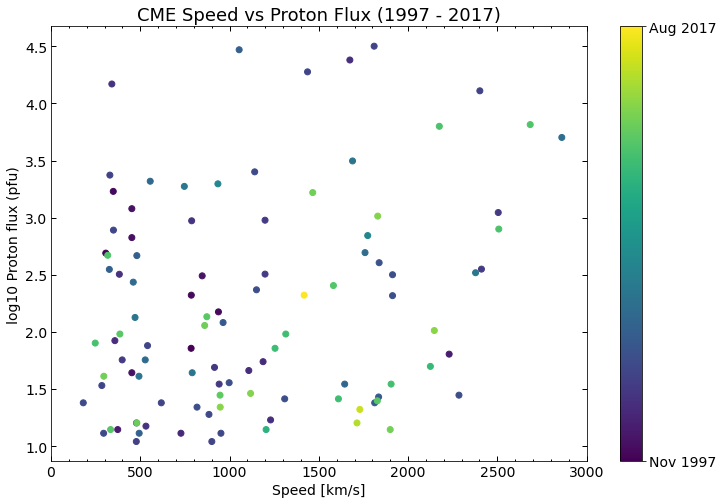

In [16]:
fig, ax = plt.subplots(figsize=[12, 8], facecolor='white')

sct = ax.scatter(fls2.cme_speed, np.log10(spf.proton_flux), c=spf.flare_max)
ax.set_title('CME Speed vs Proton Flux (1997 - 2017)', fontsize=18)
ax.set_xlabel('Speed [km/s]', fontsize=14)
ax.set_ylabel('log10 Proton flux (pfu)', fontsize=14)

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.set_xlim([0,3000])

ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis='both', length=5, top=True, right=True, direction='in', width=1)
ax.tick_params(axis='both', length=2, top=True, right=True, direction='in', which='minor', width=1)

cbar = plt.colorbar(sct, orientation='vertical', shrink=1, ticks=[0.879E18, 1.5045E18])
cbar.ax.set_yticklabels(['Nov 1997', 'Aug 2017'], fontsize=14)

#plt.savefig('speed_pfu.png', dpi=300, bbox_inches="tight", pad_inches=1)
plt.show()

## Could try filtering by location (lat-lon)

In [17]:
# df data
all_loc = df.srs_string_latlon.dropna(how='any')
sp_loc = sp.location.dropna(how='any')

In [60]:
test = all_loc.isin(sp_loc)
test = test[test]

In [61]:
test

670      True
2124     True
2212     True
2475     True
3054     True
         ... 
26275    True
27223    True
27334    True
27405    True
28778    True
Name: srs_string_latlon, Length: 108, dtype: bool